**Installation of Dependencies**

In [1]:
# Change the line to the path of your python3 interpreter
# %pip install -r requirements.txt

**Importing Dependencies**

In [2]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v6 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [3]:
# Configuration of the network
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

**Building the environment**

In [4]:
EP_LENGTH = 52 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


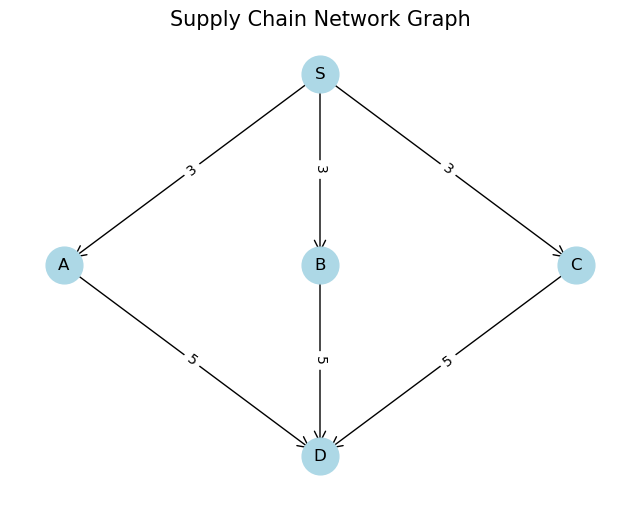

In [5]:
env.render_network()

In [6]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testing the environment**

The "agent" takes just random actions in the environment.

In [7]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        env.render()

Episode Length: 1
Stock Level: [[28. 28. 32.]]
Planned Demand: [4. 0. 0.]
Actual Demand: [2. 0. 0.]
Action: [15, 50, 15]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 50], maxlen=3),
    'C': deque([0, 0, 15], maxlen=3)}

Episode Length: 2
Stock Level: [[28. 28. 28.]]
Planned Demand: [0. 0. 6.]
Actual Demand: [0. 0. 4.]
Action: [15, 50, 15]
Order: [0 0 0]
Reward: -27.0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 15, 15], maxlen=3),
    'B': deque([0, 50, 50], maxlen=3),
    'C': deque([0, 15, 15], maxlen=3)}

Episode Length: 3
Stock Level: [[28. 28. 19.]]
Planned Demand: [ 0.  0. 11.]
Actual Demand: [0. 0. 9.]
Action: [50, 15, 0]
Order: [0 0 0]
Reward: 15.0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([15, 15, 50], maxlen=3),
    'B': deque([50, 50, 15], maxlen=3),
    'C': deque([15, 15, 

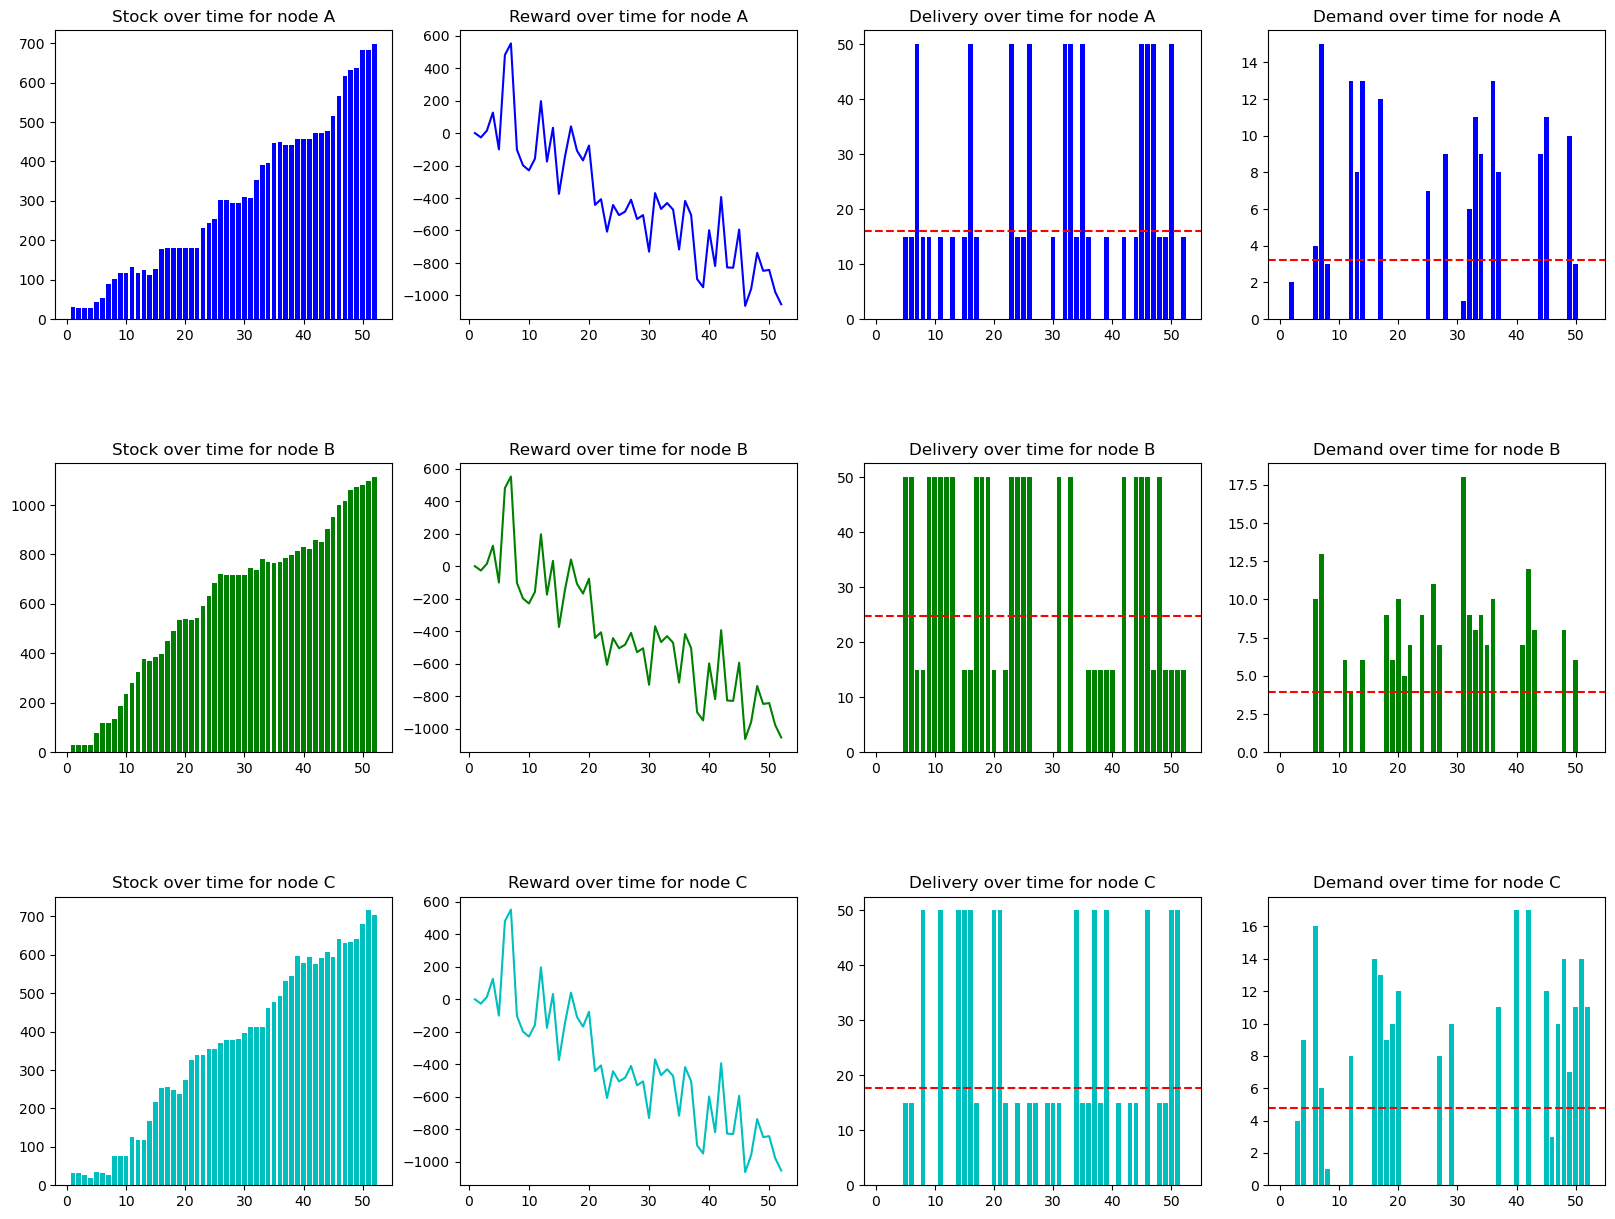

In [9]:
# Adapt the path if required
df = pd.read_csv('./Data/2024-10-25_15_last_environment_data.csv')
plot_data(df)

**Train Model**

Uncomment the code to choose which kind of model you want to train.

Currently implemented models are:
- A2C Model
- PPO Model

In [10]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')
# model_path = os.path.join('Training', 'Models', 'A2C')

In [11]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

def make_env():
    # Create a new environment here
    env = SS_Mngmt_Env(network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human")
    return env

num_envs = 8

dummy_env = DummyVecEnv([lambda: env])
vec_env = make_vec_env(make_env, n_envs=num_envs)

model = PPO("MlpPolicy", 
            dummy_env,
            learning_rate = 0.0007,
            gamma = 0.99,
            verbose=1,
            tensorboard_log=log_path)

# model = A2C("MlpPolicy",
#             vec_env,
#             learning_rate = 0.0005,
#             gamma = 0.99,
#             verbose=1,
#             tensorboard_log=log_path)

Using cpu device


Training cycle

In [12]:
model.learn(total_timesteps=100000)

Logging to Training/Logs/PPO_1
-----------------------------
| time/              |      |
|    fps             | 3243 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1958         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0039053792 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.29        |
|    explained_variance   | 8.07e-05     |
|    learning_rate        | 0.0007       |
|    loss                 | 2.21e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00313     |
|    value_loss           | 4.14e+07     |
----------------------------

In [13]:
model.save(model_path)
model.load(model_path)

evaluate_policy(model, vec_env, n_eval_episodes=10, render=True, return_episode_rewards=True)
# evaluate_policy(model, dummy_env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [[30. 28. 32.]]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [0, 0, 0]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 0], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 0], maxlen=3)}

Episode Length: 1
Stock Level: [[30. 28. 22.]]
Planned Demand: [0. 0. 9.]
Actual Demand: [ 0.  0. 10.]
Action: [0, 0, 0]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 0], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 0], maxlen=3)}

Episode Length: 1
Stock Level: [[20. 28. 21.]]
Planned Demand: [11.  0. 12.]
Actual Demand: [10.  0. 11.]
Action: [15, 0, 0]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 0], maxlen=3)}

Episode 

([-35358.0,
  -42086.0,
  -43547.5,
  -44385.0,
  -42126.0,
  -40728.5,
  -25352.0,
  -11256.5,
  -24708.5,
  -38684.0],
 [52, 52, 52, 52, 52, 52, 52, 52, 52, 52])

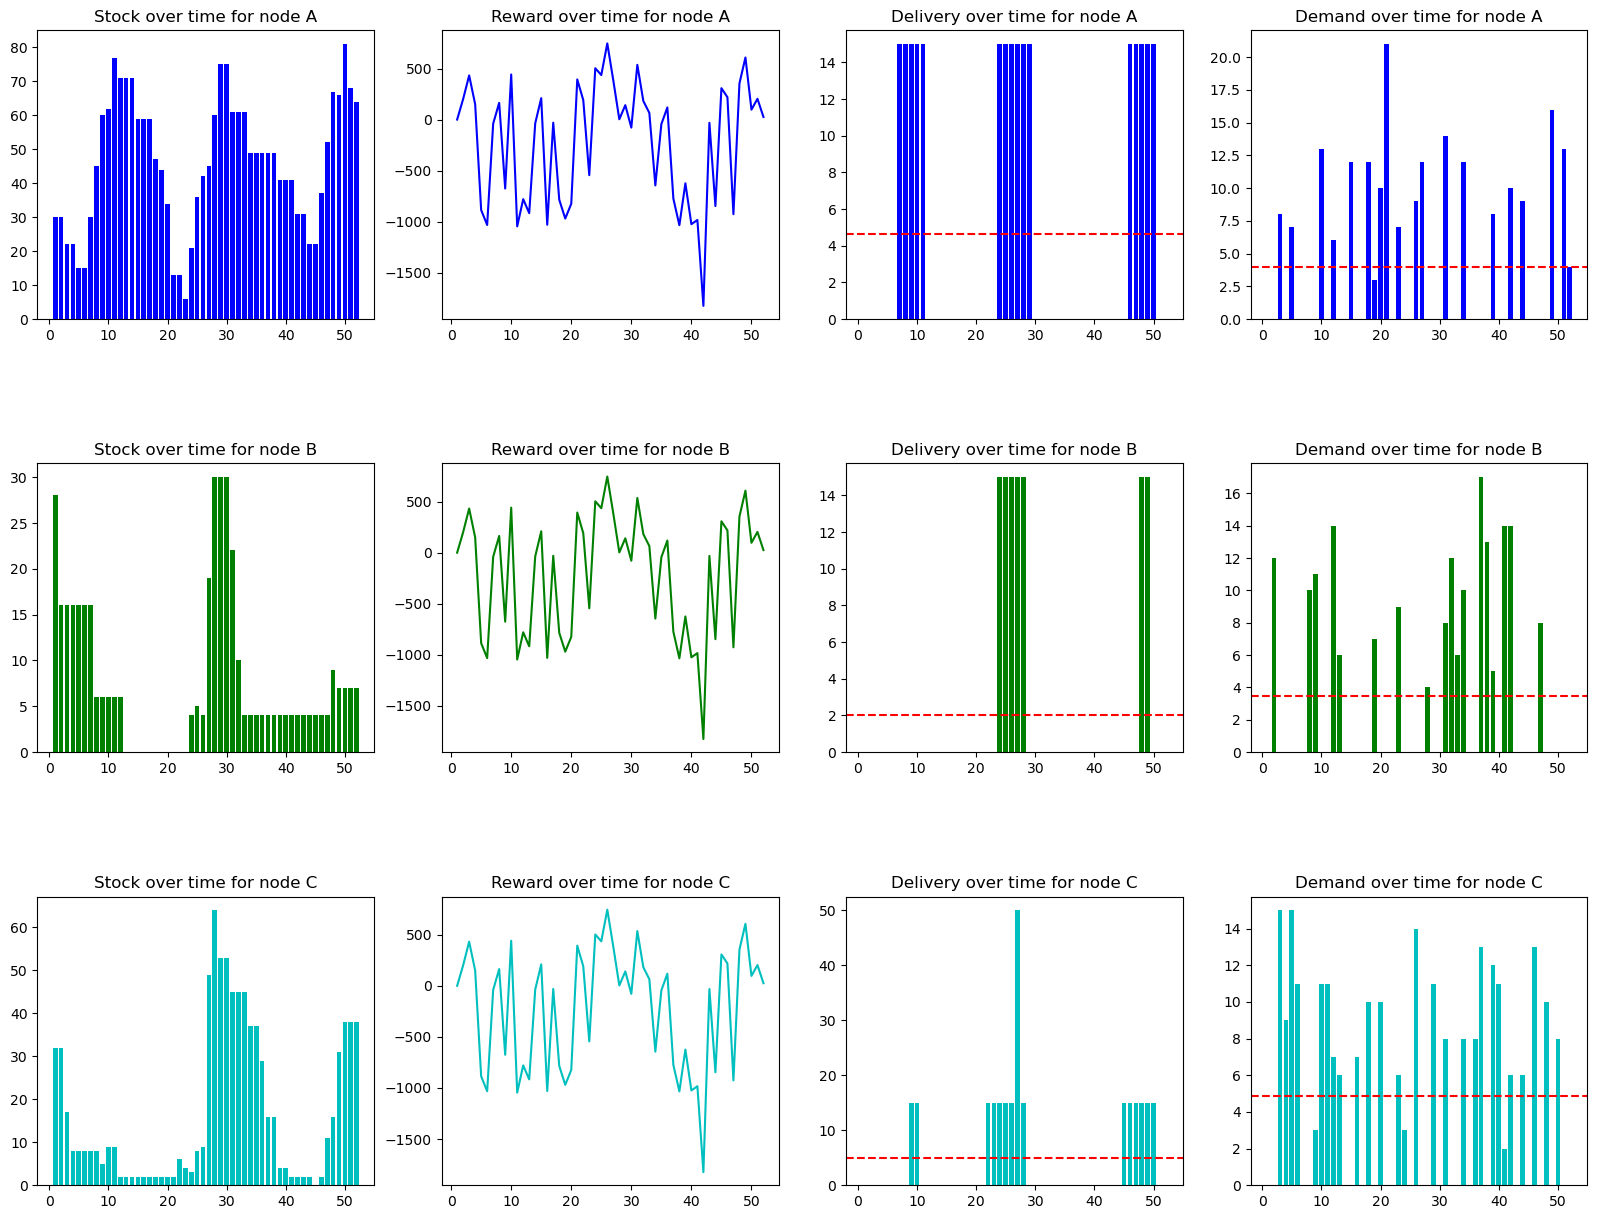

In [15]:
# Adapt the path if required
file = './Data/2024-10-25_15_last_environment_data.csv'
df = pd.read_csv(file)

plot_data(df)